# Test MP Data

L'objectif de ce projet est de construire un modèle capable de prédire si un joueur de NBA va rester plus de 5 ans dans le championnat, et donc si il est intérssant de le sponsoriser, à partir de ses statistiques de jeu.
Pour cela nous avons à notre disposition un jeu de donnée avec les statistiques de match de certains joueurs, et si ils ont duré plus de  ans dans le championnat.

Ce notebook présente la partie analyse des donnée et construction du modèle.
La partie API Rest est disponible dans le dossier DjangoAPIMPData en executant la commande:

python manage.py runserver

L'API est ensuite utilisable avec l'application Postman. Le format d'entrée est du Json, la requête est envoyé via la commande POST.

## Import de librairies

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

import joblib

pd.set_option('display.max_columns', None)

## Import du jeu de donées et premières descriptions

In [3]:
# Load dataset
df = pd.read_csv("nba_logreg.csv")
df

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,1.2,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,0.8,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,1.0,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,1.2,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


Le jeu de donnée contient les statistiques de match de 1340 joueurs, avec 19 statistiques disponibles pour chacun des joueurs

In [4]:
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

On voit que le jeu de donnée est propre, il n'y a pas de valeur manquante, toutes les variables sont des flottants.

## Etude descriptive

Text(0.5, 1.0, 'Distribition de la variable cible')

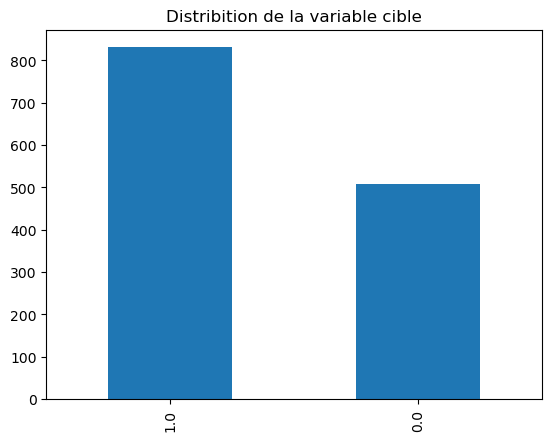

In [6]:
df['TARGET_5Yrs'].value_counts().plot(kind='bar')
plt.title("Distribition de la variable cible")

La figure ci-dessus présente la répartition de la variable cible. On voit que celle-ci est légèrement déséquilibrée, il y eu plus de joueurs qui ont duré plus de 5 ans que l'inverse. Néanmoins, ce déséquilibre n'est pas trop important et ne devrait gêner la construction du modèle.

### Analyse de la variable PTS

La moyenne de points par match est de 6.8 points, la médiane est à 5.55 points et l'écart-type vaut 4.36 points
Le minimum est à 0.7 points de moyenne et le max est à 28.2 points de moyenne


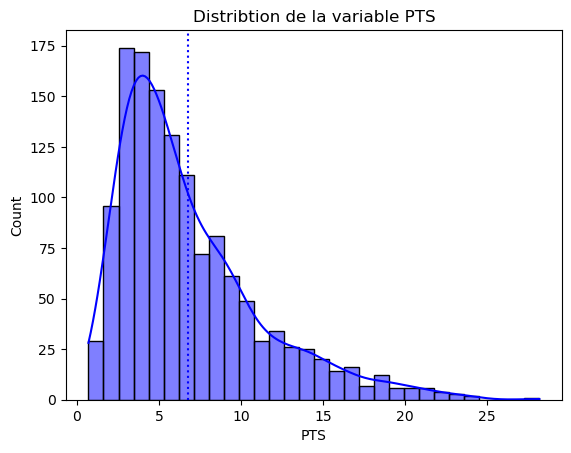

In [7]:
PTS = df["PTS"]

fig, ax = plt.subplots()
sns.histplot(PTS, color="blue", kde = True, ax = ax)
ax.set_title("Distribtion de la variable PTS")
mean = PTS.mean()
std = PTS.std()
median = PTS.median()
maxi = PTS.max()
mini = PTS.min()
plt.axvline(mean, 0, color='blue', ls=':')

print(f"La moyenne de points par match est de {np.round(mean,2)} points, la médiane est à {median} points et l'écart-type vaut {np.round(std,2)} points")
print(f"Le minimum est à {mini} points de moyenne et le max est à {maxi} points de moyenne")


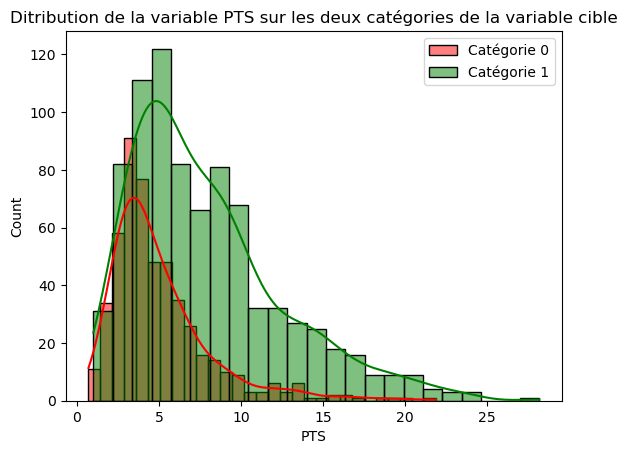

In [8]:
df0 = df[df["TARGET_5Yrs"] == 0]
df1 = df[df["TARGET_5Yrs"] == 1]
PTS0 = df0["PTS"]
PTS1 = df1["PTS"]

fig, ax = plt.subplots()
sns.histplot(PTS0, color="Red", kde = True, ax = ax, label = "Catégorie 0")
sns.histplot(PTS1, color="Green", kde = True, ax = ax, label = "Catégorie 1")
ax.set_title("Ditribution de la variable PTS sur les deux catégories de la variable cible")
ax.legend()

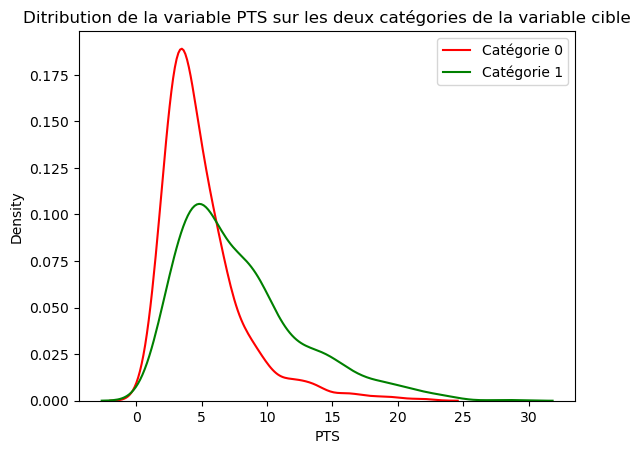

In [9]:
fig, ax = plt.subplots()
sns.kdeplot(PTS0, color="Red", ax = ax, label = "Catégorie 0")
sns.kdeplot(PTS1, color="Green", ax = ax, label = "Catégorie 1")
ax.set_title("Ditribution de la variable PTS sur les deux catégories de la variable cible")
ax.legend()

On observe sur les courbes de distribution que la distribution de la variable PTS est assez différente selon la catégorie de la variable cible. La variable PTS semble donc être une variable discriminante pour réaliser la classification.

On pourrait réaliser une étude plus approfondie sur chacune des variables pour s'assurer de la qualité de la donnée et de son caractère discirimantoire vis-a-vis de la variable cible.

## Relation entre les variables

/var/folders/8g/31xb0b_x60n2898lfpr8b6bh0000gp/T/ipykernel_17110/2166861436.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap='inferno',mask=np.triu(df.corr(),k=1))


<Axes: >

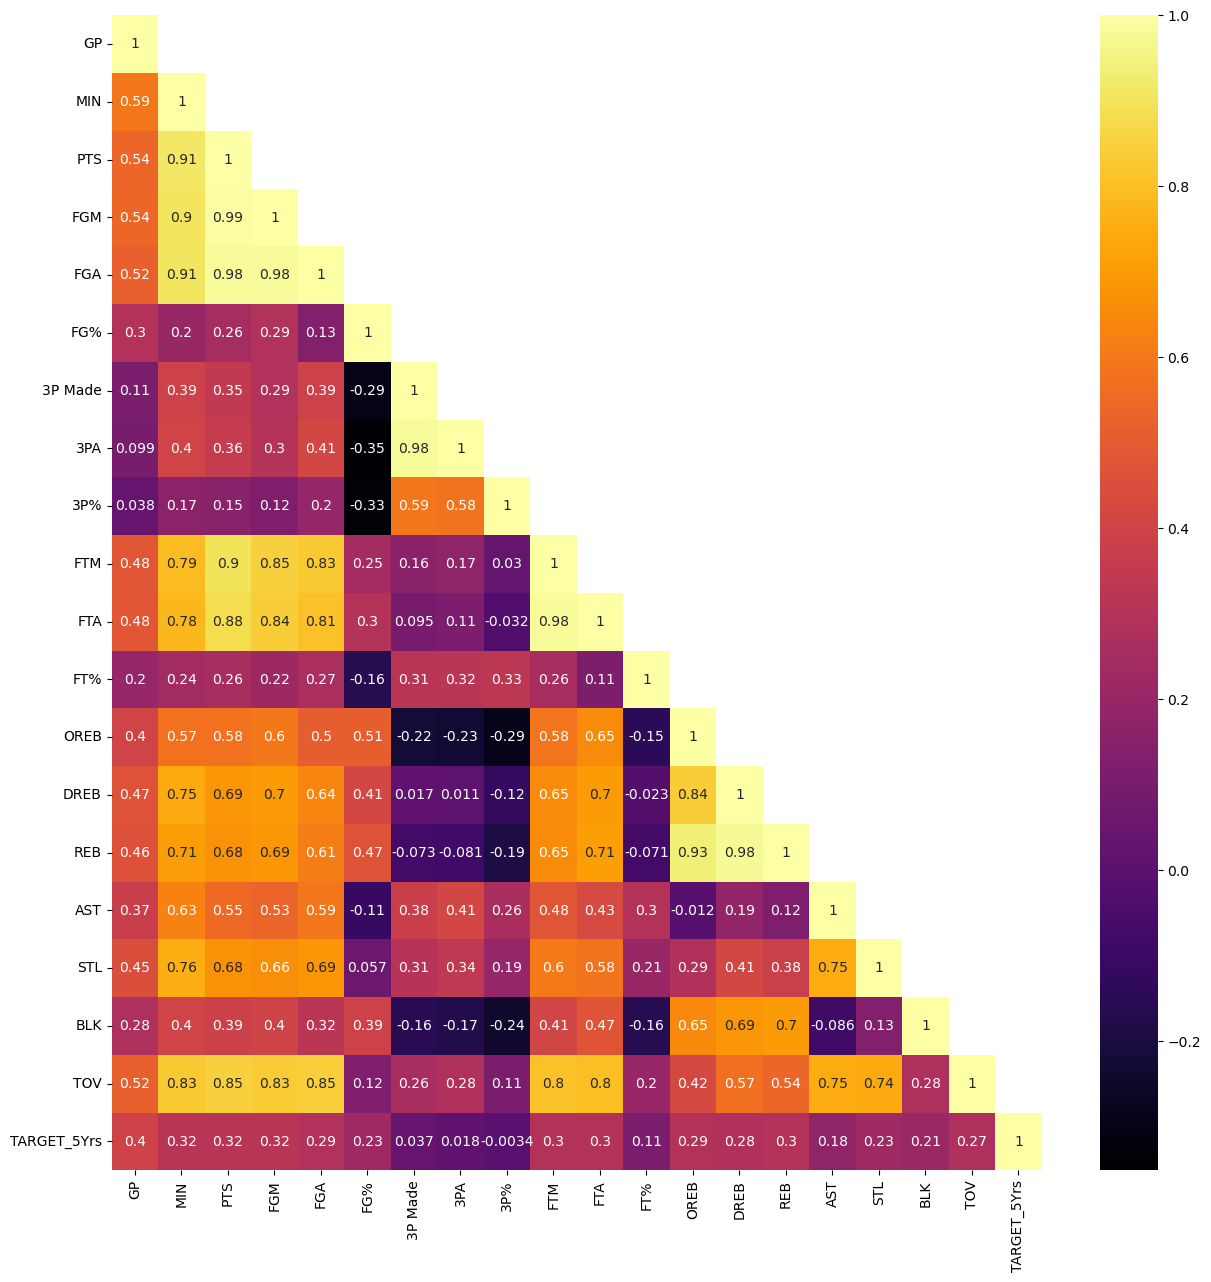

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap='inferno',mask=np.triu(df.corr(),k=1))

Cette matrice de corrélation nous montre que certaines statistiques de jeu sont fortement corrélées entre elles. Les variables PTS, FGA, FGM ont par exemple des coefficients de corrélation supérieur à 0.9. Certains modèles sont sensibles à la colinéarité des variables, il pourrait alors être nécéssaire de supprimer certaines variables pour la construction du modèle.

In [11]:
#df = df.drop(['TARGET_5Yrs','Name', 'FGA','DREB','FGM', 'OREB', '3PA', 'FTM'],axis=1)
#plt.figure(figsize=(15,15))
#sns.heatmap(df_vals.corr(),annot=True,cmap='inferno',mask=np.triu(df_vals.corr(),k=1))

## Pré traitement des données

In [12]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
y = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
#df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

In [13]:
# normalize dataset
scaler = MinMaxScaler().fit(df_vals) 
X = scaler.transform(df_vals)

scaler_filename = "APILilian/scaler.pkl"
joblib.dump(scaler, scaler_filename)

# On normalise le dataset et on sauvegarde la transformation de donnée 
# dans un fichier pickle

['APILilian/scaler.pkl']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = 0.2)

## Création du jeu de donnée d'entrainement et de test

Par expérience les méthodes de bagging et de boosting ont tendance à de bons résultats sur ce type de problématique. Le modèle développé ici est un modèle de XGBoost. On va alors trouver les meilleurs hyperparamètres du modèle par validation croisée.

Une étude plus approfondie permettrait d'explorer plus de modèle de classification, type regression logistique, SVC, KNN, Réseau de neurones etc. Il aurait également été intéressant d'explorer les résultats donnés par de nouvelles architectures comme TabNet. A partir d'un tableau de donnée brut type DataFrame sans pré tratiement des données, TabNet utilise des réseaux de neurones et des mécanismes d'attention afin de déterminer de manière autonome les variables à utiliser dans chacune des étapes de décision.

## Création du modèle, optimisation des hyperparamètres et entrainement

In [15]:
xgb_opt = xgb.XGBClassifier(seed = 42)

params = { 'max_depth': [3,5,8],
           'learning_rate': [0.01, 0.03],
           'n_estimators': [300, 500],
           'colsample_bytree': [0.8, 1]}

xgb_gscv = GridSearchCV(estimator=xgb_opt, 
                   param_grid=params,
                    scoring='accuracy',
                   verbose=5)

xgb_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.740 total time=   0.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.730 total time=   0.2s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.734 total time=   0.2s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.673 total time=   0.3s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.673 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.740 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.721 total time=   0.4s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.720 total time=  

[CV 1/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=300;, score=0.730 total time=   0.5s
[CV 2/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=300;, score=0.716 total time=   0.5s
[CV 3/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=300;, score=0.734 total time=   0.5s
[CV 4/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=300;, score=0.659 total time=   0.5s
[CV 5/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=300;, score=0.682 total time=   0.5s
[CV 1/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.735 total time=   0.7s
[CV 2/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.688 total time=   0.7s
[CV 3/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.729 total time=   0.7s
[CV 4/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_esti

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.03], 'max_depth': [3, 5, 8],
                         'n_estimators': [300, 500]},
             scoring='accuracy', verbose=5)

On cherche ici les hyperparamètres permettant de maximiser l'accuracy du modèle, c'est à dire son nombre de prédictions correctes.

On garde ensuite le modèle ayant donné les meilleurs résultats pour la suite de l'étude.

In [16]:
print("Best parameters:", xgb_gscv.best_params_)
print("Best score: ", xgb_gscv.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300}
Best score:  0.7117191914801129


## Résultats et performances du modèle

Text(0.5, 1.0, 'Confusion Matrix')

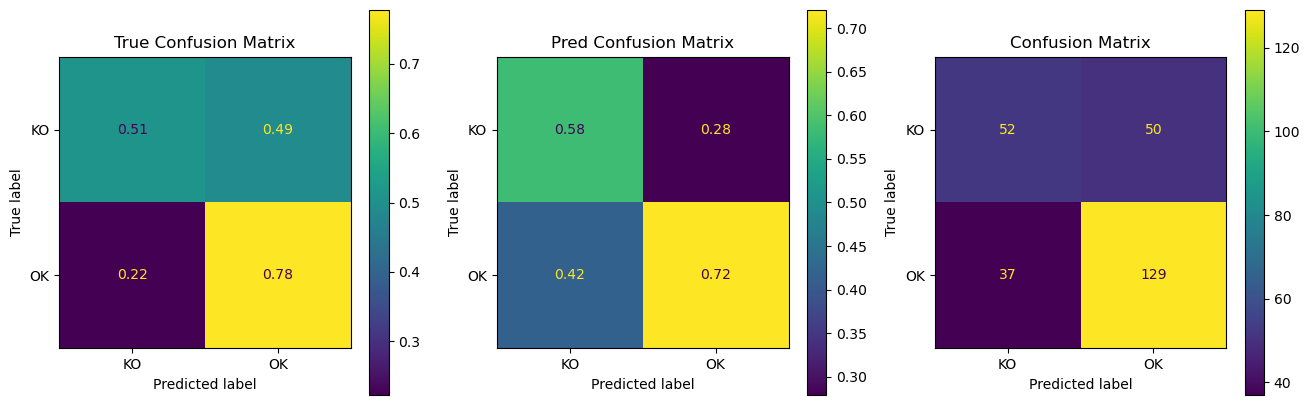

In [17]:
y_pred = xgb_gscv.predict(X_test)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

C = confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=['KO', 'OK'])
_.plot(ax=ax[0])
ax[0].set_title('True Confusion Matrix')

C = confusion_matrix(y_test, y_pred, normalize='pred')
_ = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=['KO', 'OK'])
_.plot(ax=ax[1])
ax[1].set_title('Pred Confusion Matrix')

 
C = confusion_matrix(y_test, y_pred, normalize=None)
_ = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=['KO', 'OK'])
_.plot(ax=ax[2])
ax[2].set_title('Confusion Matrix')

Les matrices de confusion affichées ici donnent un premier apercu des performances du modèle. Néanmoins, le seuil de classfication est défini par défaut à 0.5. Nous allons voir dans les cellues suivantes comment définir au mieux ce seuil afin d'ajuster le modèle aux besoins de la demande client.

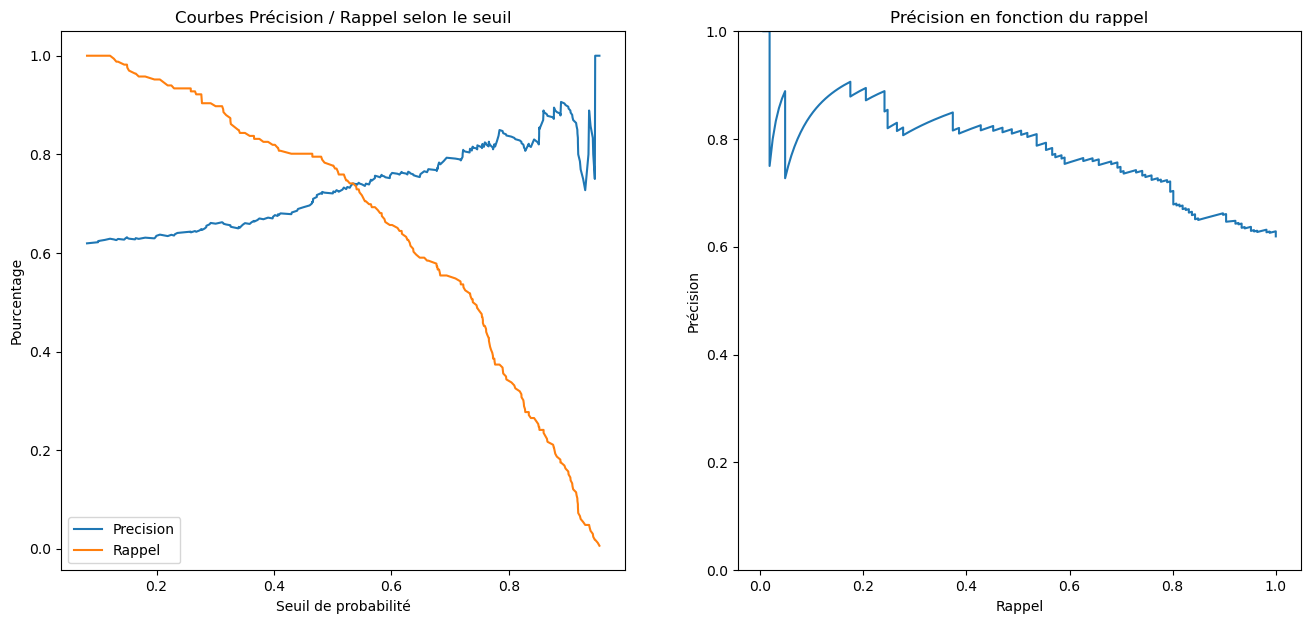

In [18]:
proba_pred_X_test_XGB = xgb_gscv.predict_proba(X_test)[:,1] ### Proba que le joueur soit gardé sur les 5 prochaines années

precision, recall, thresholds = precision_recall_curve(y_test, proba_pred_X_test_XGB)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

ax[0].plot(thresholds, precision[:-1], label='Precision')
ax[0].plot(thresholds, recall[:-1], label='Rappel')
ax[0].set_xlabel("Seuil de probabilité")
ax[0].set_ylabel('Pourcentage')
ax[0].set_title('Courbes Précision / Rappel selon le seuil')
ax[0].legend()

plt.plot(recall[:-1], precision[:-1])
ax[1].set_xlabel('Rappel')
ax[1].set_ylabel('Précision')
ax[1].set_ylim(0,1)
ax[1].set_title('Précision en fonction du rappel')

plt.show()

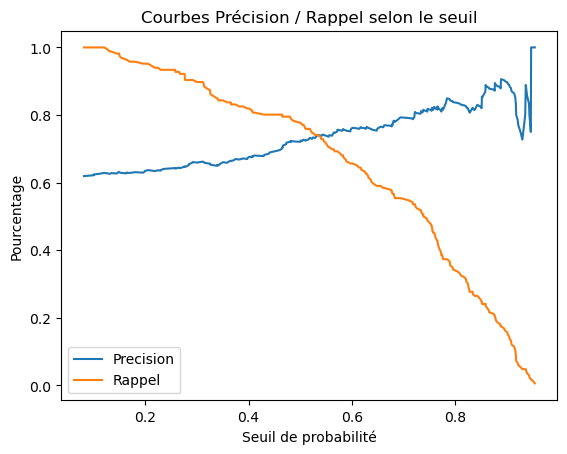

In [19]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], label='Precision')
ax.plot(thresholds, recall[:-1], label='Rappel')
ax.set_xlabel("Seuil de probabilité")
ax.set_ylabel('Pourcentage')
ax.set_title('Courbes Précision / Rappel selon le seuil')
ax.legend()

plt.show()

Les courbes de precision et rappel ci-dessus nous aident à définir le seuil du modèle. Le seuil est alors à choisir en échangeant avec le métier. Si l'objectif est de rater le moins possible de joueurs qui resteront dans les 5 prochaines années, le seuil sera bas afin de maximiser le rappel. Au contraire, si l'objectif est de ne surtout pas signer des joueurs qui ne resteront pas dans les 5 prochaines années, car ces joueurs peuvent faire perdre de l'argent, alors le seuil de probabilité sera placé élevé afin de favorsier la précision au détriment du rappel. 

Le compromis entre volume, rappel et précision est donné par la courbe ci-dessus. Si par exemple, l'objectif du métier est d'identifier et de séléctionner 90% du volume des joueurs qui resteront dans le championnat dans les 5 prochaines années, afin de ne manquer aucun joueur prometteur, on définira le seuil du modèle à 0.3 environ. Néanmoins à ce seuil, on voit que la précision est d'environ 65%, ce qui veut dire que 35% des joueurs séléctionnés ne resteront pas dans le championnat dans les 5 prochaines années, ce qui peut couter cher au sponsor.

Le seuil est donc à définir avec les métiers, pour que le modèle corresponde bien à leurs attentes.

## Autres remarques

Dans le cadre d'un modèle permettant de prédire si un joueur de NBA est intéressant à sponsoriser, il pourrait être intéressant d'aller au-delà des statistiques de jeu. En effet, la valeur marchande d'un joueur n'est pas uniquement définie par ses performances sportives, mais aussi par ses apparitions dans les médias, sa présence sur les réseaux, sa côte de popularité etc. Il existe des profils de joueurs relativement performants sur le plan sportif mais ne suscitant pas beaucoup d'enthousiasme car de nature plus réservée et discrets en dehors des parquets, ils proposant donc moins de visibilité aux marques.

Il serait alors intéressant de rajouter d'autres données pour décrire la popularité et la visibilité d'un joueur afin d'affiner le modèle.

Le modèle pourrait également se transformer en modèle de régression, capable d'évaluer la valeur marchande d'un joueur, afin de proposer des contrats adaptés à la valeur de chaque joueur. Ce modèle permettrait une maitrise des couts et un meilleur retour sur investissement pour les marques.

## Sauvegarde du modèle

In [20]:
model = xgb_gscv
model_filename = "APILilian/model.pkl"
joblib.dump(model, model_filename)

['APILilian/model.pkl']

In [21]:
## Fonction MP Data

def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=3
    
    print(confusion_mat)
    print(recall)

In [22]:
#example of scoring with support vector classifier
#score_classifier(X,SVC(),y)
#score_classifier(X_train,SVC(),y_train)

In [23]:
joueur_test = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
joueur_test = [np.array(joueur_test)]
joueur_transform = scaler.transform(joueur_test)

proba_pred = model.predict_proba(joueur_transform)
proba_pred

array([[0.67663467, 0.32336536]], dtype=float32)